# Simple Features exploration

We design some simple features (important in a limited quantity) and explore modeling on all combinations of features.

## Global Process

1. Add features to the input data
2. Generate some weights so distribution of is_duplicate in training matches the one in challenge data
3. Do some basic exploration of each unique feature. Is there any chance it can help to separate is_duplicate
4. Pick an algorithm
5. Explore all combination of features. 8 features generate 255 combinations
6. For each combination
    * 2 models are generated : 80,20 and 100,0 partitions
    * for each model, we keep
        ** logloss : the main metric choosen for the challenge
        ** accuracy
        ** score ie f1-score
        ** the combination of features
        ** the model
6. This 'database' of results is saved (excel and pickle)
7. Using this 'database' of results, we do some graphs
8. We choose the best models for a given metric and apply them to challenge data
9. Scorings are submitted to Kaggle
10. Evaluations from kaggle are downloaded and graphed

## Training of models
Code is available for 3 'strategies' to built each model
### All default parameters
Obviously, the fastest
### All default parameters with cross validation
Only one model is built. There is no 80,20/100,0 as all is driven by cross validation
For each iteration, we store more informations
    * for each metric: min,max,mean,std, best fold
    * model
The best fold for a given gives the best model. Currently, there is no dramatic difference between min,max and mean of each metric
Still, Kaggle score is little bit better
### Exploration of Hyper parameters 

A search for best parameters is done via:
    * RandomizedSearchCV
    * GridSearchCV

Currently and strangely, strategy with hyper parameters is under Simple Cross Validatin but this may change with algorithms and new features






In [10]:
# Ugly incantation to make our 'framework' working
import sys
sys.path.insert(0, r'/SAPDevelop/QuoraPairs/BruteForce/Tools')

#import all our small tools (paths, cache, print,zip,excel, pandas, progress,..)
from Tools.all import *

# setup the name of our experiment
# it will be used to store every result in a unique place
EXPERIMENT='more_features_exploration'
# Do a bit of checks before actually running code
UNITARY_TEST = True
print_alert('You will use environment %s' % EXPERIMENT)

## Build our simple features
* Nb words in question 1
* Nb words in question 2
* **abs(Nb words in question 1 - Nb words in question 2)** suppressed
* Nb common words
* Nb common words/nb words in question 1
* Nb common words/nb words in question 2
* Nb non common words in question 1
* Nb non common words in question 2
* Nb common words/(Nb words in question1 + Nb words in question2)

**Notes**
* Input data is not processed except for basic unicode clean
* Heavy to generate so result is cached
* This may be overkill as features will be eliminated but features are also generated for challenge data

In [11]:
def add_column_from_columns(dataframe,output_column_name,function):
    dataframe[output_column_name]=dataframe.progress_apply(function,axis=1)
    return dataframe[output_column_name]

def add_column_from_column(dataframe,output_column_name,input_column_name,function):
    dataframe[output_column_name]=dataframe[input_column_name].progress_apply(function)
    return dataframe[output_column_name]

def build_all_simple_features(dataframe):
    print_warning('Compute common_words between question1 & question2')
    add_column_from_column(dataframe,'nb_words_question1','question1',lambda x: len(x.split()))
    add_column_from_column(dataframe,'nb_words_question2','question2',lambda x: len(x.split()))

    #print_warning('Compute abs(Nb words in question 1 - Nb words in question 2)')
    #add_column_from_columns(dataframe,'abs(nb1-nb2)',lambda r: abs(r.nb_words_question1-r.nb_words_question2))

    print_warning('Compute Nb common_words between question1 & question2')
    add_column_from_columns(dataframe,'common_words',lambda r: list(set(r.question1.split())&set(r.question2.split())))
    add_column_from_column(dataframe,'nb_common_words','common_words',len)

    print_warning('Compute Nb common words/nb words in question1')
    add_column_from_columns(dataframe,'nb_common_words/nb_words_question1',lambda r: r.nb_common_words/max(1,r.nb_words_question1))
    print_warning('Compute Nb common words/nb words in question2')
    add_column_from_columns(dataframe,'nb_common_words/nb_words_question2',lambda r: r.nb_common_words/max(1,r.nb_words_question2))

    print_warning('Compute Nb words in question1,question2 not in common words')
    add_column_from_columns(dataframe,'nb_words_question1-common_words',lambda r: len(list(set(r.question1.split())-set(r.common_words))))
    add_column_from_columns(dataframe,'nb_words_question2-common_words',lambda r: len(list(set(r.question2.split())-set(r.common_words))))
    print_warning('Compute (nb common words)/(nb words in question1+nb word in question2)')
    add_column_from_columns(dataframe,'nb_common_words/(nb_words_question1+nb_words_question2)',lambda r: r.nb_common_words/(r.nb_words_question1+r.nb_words_question2))
    dataframe=dataframe.drop(columns='common_words')
    return dataframe

In [12]:
prepare_environnement(EXPERIMENT)
train_dataframe=load_dataframe(CLEAN_TRAINING_DATA)
challenge_dataframe=load_dataframe(CLEAN_CHALLENGE_DATA)
print_section('Untouched input data has been loaded. Training: %d lines Challenge: %d lines' % (len(train_dataframe),len(challenge_dataframe)))

train_dataframe=load_or_build_dataframe('Training data + basic features','training_basic_features',build_all_simple_features,train_dataframe)
challenge_dataframe=load_or_build_dataframe('Challenge data + basic features','challenge_basic_features',build_all_simple_features,challenge_dataframe)

## Challenge and training are not equivalent

% of duplicate in training is not the same in challenge !
We don't have the challenge's answer but by scoring a constant prediction and using logloss definition, we can guess the distribution of duplicates in challenge

It's 17.46 %

To fix that we can:

* duplicate some negative cases in training to match challenge distribution
* use weights : each case has a weight !=1 and all algorithms are supposed to be able to deal with that info
I choose to use weights (less memory needed ?)

In [13]:
# return the weight for 0 and weight for 1 needed to rebalance dataframe like challenge
def balanced_weights(dataframe,expected_positive_ratio):
    current_positive_ratio = dataframe['is_duplicate'].sum()/len(dataframe)
    weight_for_negative = (1-expected_positive_ratio)/(1-current_positive_ratio)
    weight_for_positive = expected_positive_ratio/current_positive_ratio
    return weight_for_positive,weight_for_negative
    return 1,


CHALLENGE_DUPLICATE_PERCENT = 0.1746
print_warning('OUPS !! %% of duplicates in train is %.3f. In challenge it is %.3f %%' % (train_dataframe['is_duplicate'].sum()/len(train_dataframe),CHALLENGE_DUPLICATE_PERCENT))

# create a new 'weight' column to training dataset
# Do not forget to remove this column from features !!!
weight_for_1,weight_for_0 = balanced_weights(train_dataframe,CHALLENGE_DUPLICATE_PERCENT)
print_info('Weight for positive case %.3f' % weight_for_1)
print_info('Weight for negative case %.3f' % weight_for_0)
train_dataframe['weight'] = train_dataframe['is_duplicate'].map( {0:weight_for_0, 1:weight_for_1})

assert int(train_dataframe['weight'].sum()/len(train_dataframe)) == 1, "training dataset has not been properly rebalanced"
print_info("Training data set has been properly rebalanced")
print_info('Weights distribution:')
train_dataframe['weight'].describe()

count    404290.000000
mean          1.000000
std           0.403239
min           0.472917
25%           0.472917
50%           1.308493
75%           1.308493
max           1.308493
Name: weight, dtype: float64

## Compute AUC of these basic features and try to figure if there is a bit of information inside each one

ie is it helping to separate 1 from 0?

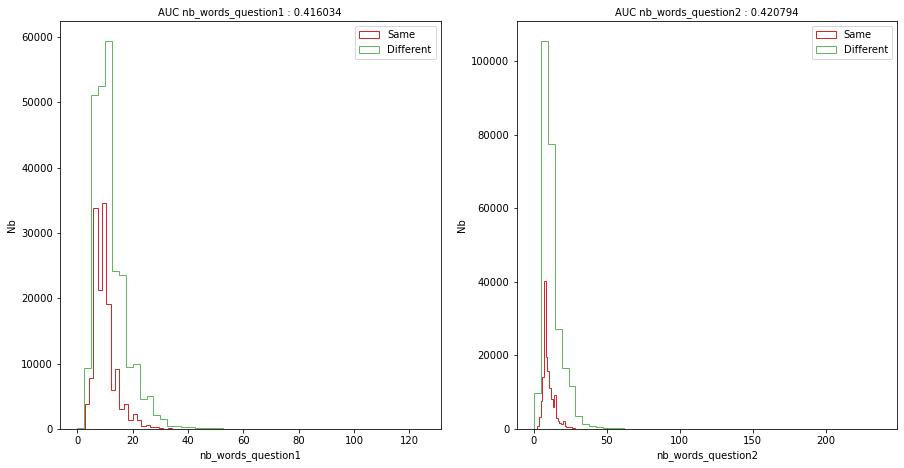

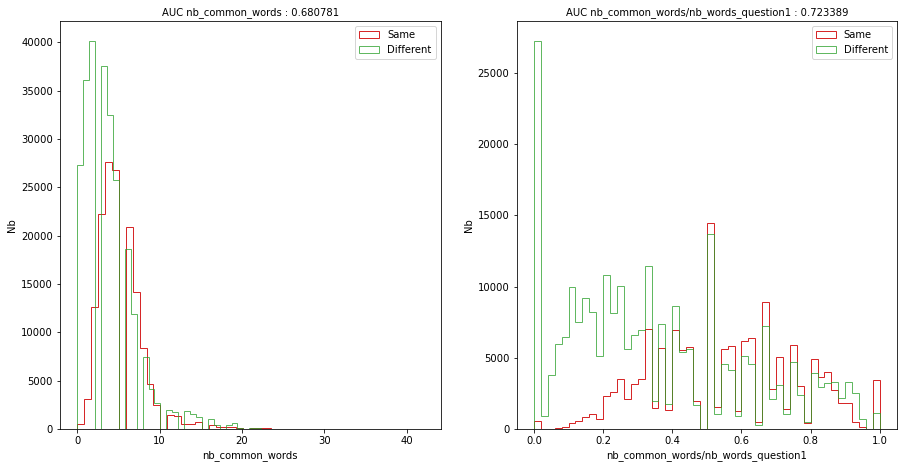

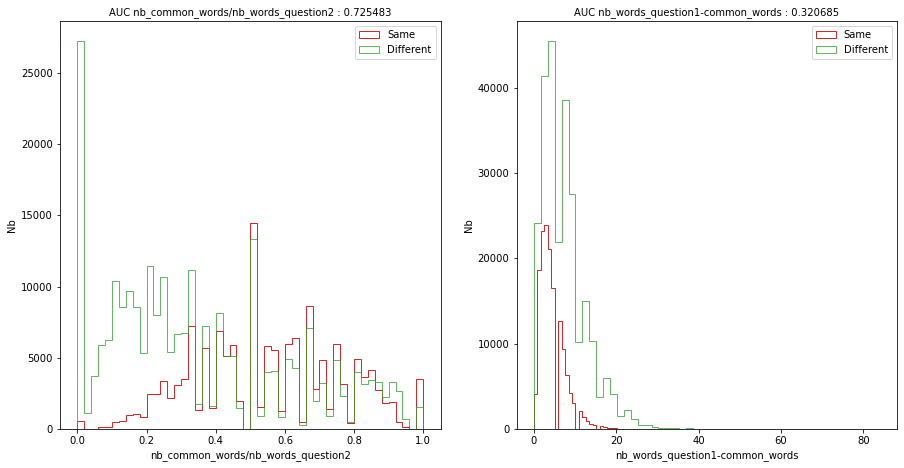

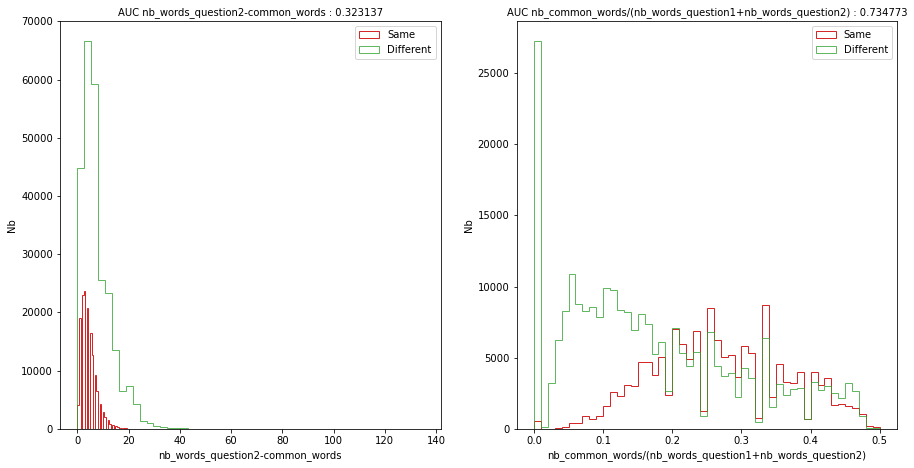

In [14]:
from sklearn.metrics import roc_auc_score

def simple_AUC(dataframe,column_name):
    return roc_auc_score(y_true=dataframe['is_duplicate'],y_score=dataframe[column_name])

def simple_weighted_AUC(dataframe,column_name):
    return roc_auc_score(y_true=dataframe['is_duplicate'],y_score=dataframe[column_name],sample_weight=dataframe['weight'])

def show_AUC(dataframe,column_name):
    print_bullet('AUC %s: %f' % (column_name,simple_AUC(dataframe,column_name)))
    if 'weight' in dataframe.columns:
        print_bullet('Weighted AUC %f' % simple_weighted_AUC(dataframe,column_name))
    else:
        print_bullet('AUC %f' % simple_AUC(dataframe,column_name))
        

def display_simple_AUC(dataframe,column_name):
    palette = sns.color_palette()
    # Let multiplot_generator figure the size
    #plot.figure(figsize=(10, 7))
    plot.hist(dataframe[column_name][dataframe['is_duplicate']==1],bins=50,color=palette[3],label='Same',histtype='step')
    plot.hist(train_dataframe[column_name][dataframe['is_duplicate']==0],bins=50,color=palette[2],label='Different',alpha = 0.75,histtype='step')
    plot.title('AUC %s : %f' % (column_name,simple_AUC(dataframe,column_name)) , fontsize=10)
    plot.xlabel(column_name)
    plot.ylabel('Nb')
    plot.legend()



def show_all_simple_AUC(dataframe):
    all =  all_numeric_columns(dataframe)
    print_section( 'Show AUC on %d unique features' % len(all))
    for name in all:
        show_AUC(dataframe,name)
        yield
        display_simple_AUC(dataframe,name)
    print_done('Done')


def show_all_simple_AUC_in_grid(dataframe,nb_columns=2):
    multiplot_from_generator(show_all_simple_AUC(dataframe), nb_columns)

show_all_simple_AUC_in_grid(train_dataframe,nb_columns=2)

## OK Visualising these AUC is cool
Can we have some numbers ?

is_duplicate                                               1.000000
nb_common_words/(nb_words_question1+nb_words_question2)    0.370994
nb_common_words/nb_words_question2                         0.359681
nb_common_words/nb_words_question1                         0.358852
nb_words_question1-common_words                            0.301578
nb_words_question2-common_words                            0.295709
nb_common_words                                            0.225751
nb_words_question2                                         0.160401
nb_words_question1                                         0.154250
Name: is_duplicate, dtype: float64


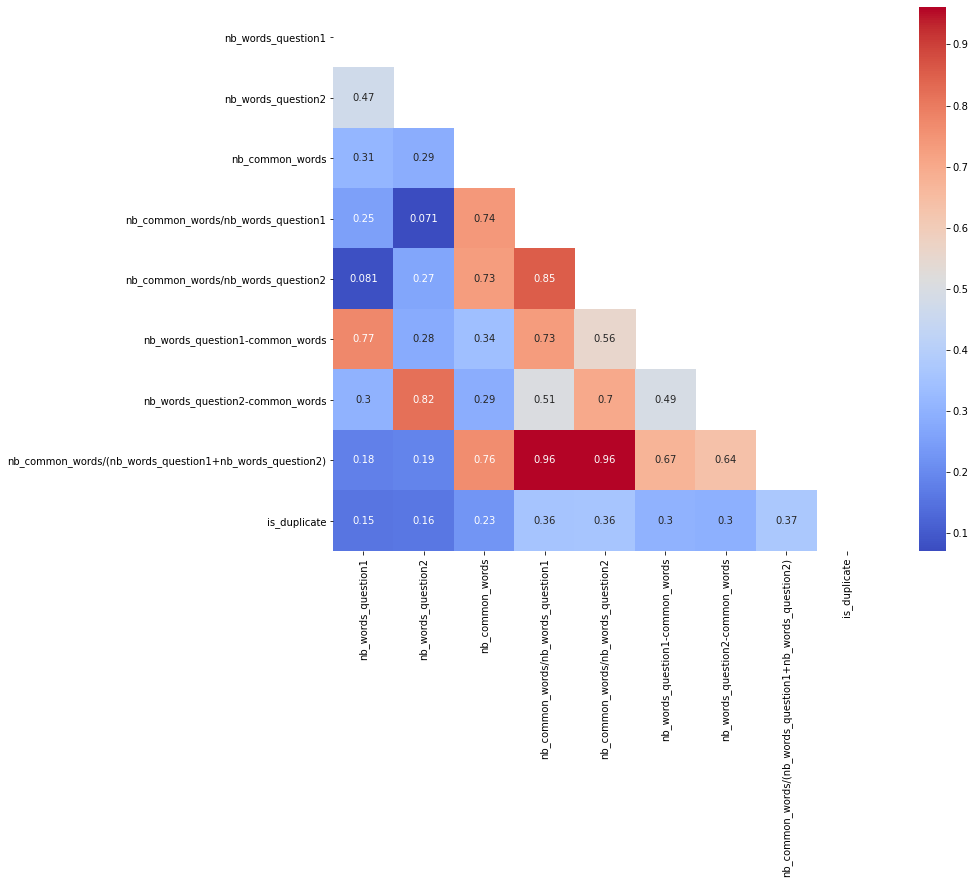

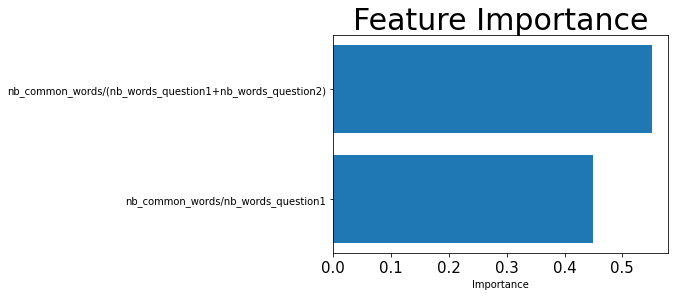

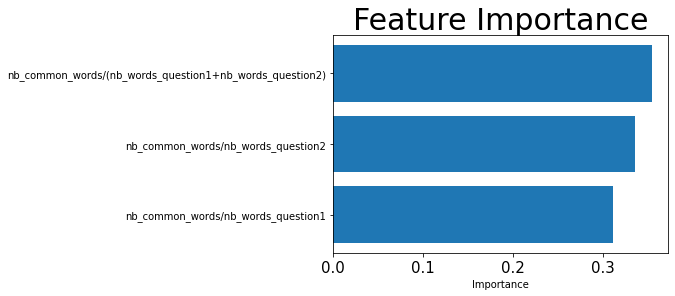

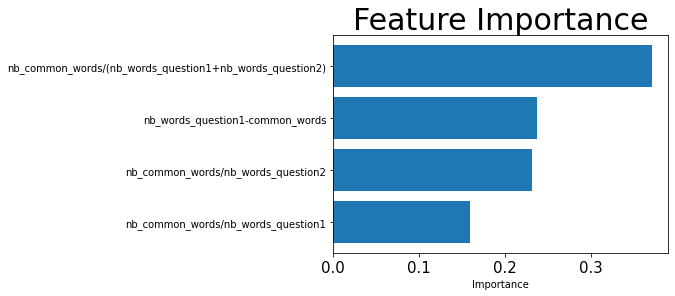

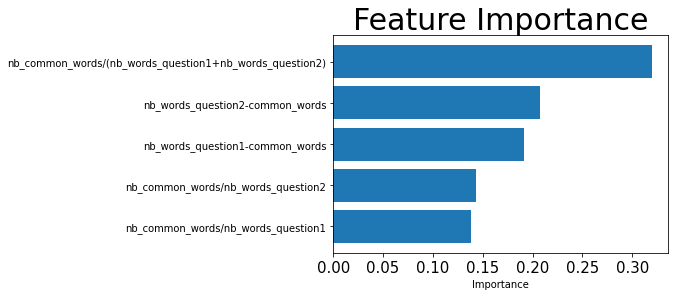

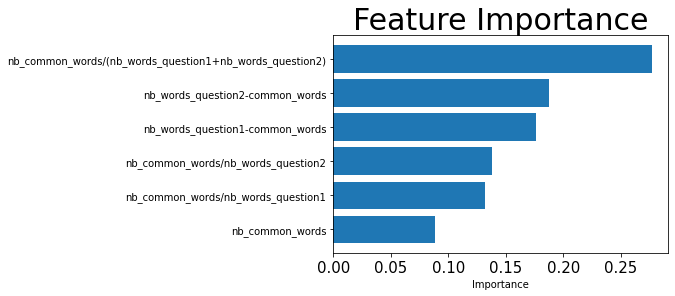

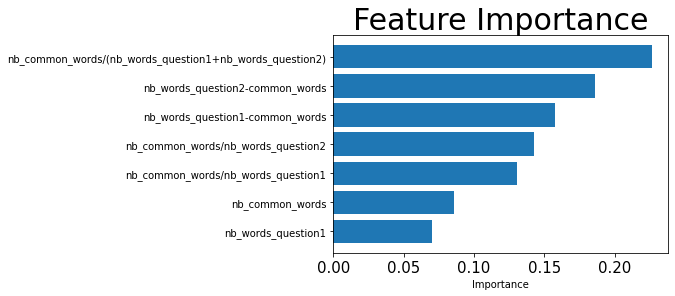

[3 4 7]
[0.32733474 0.34885325 0.32381201]


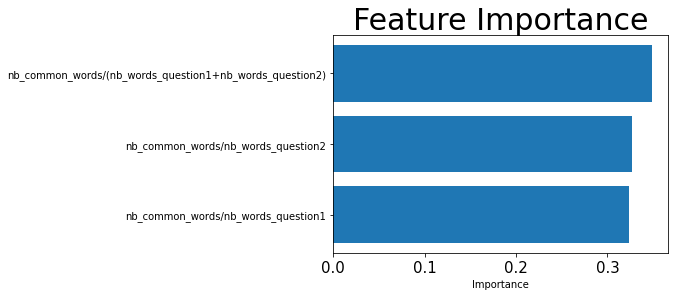

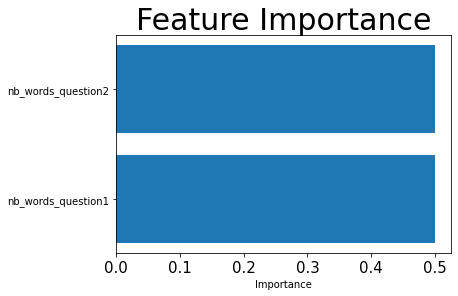

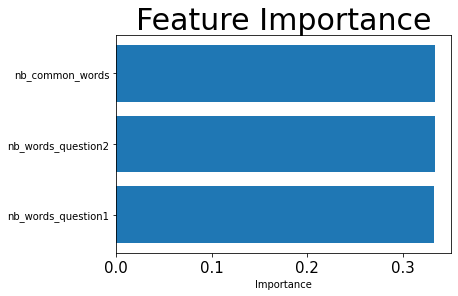

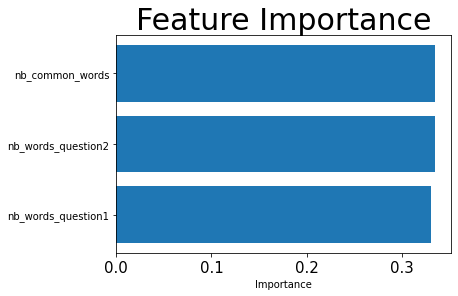

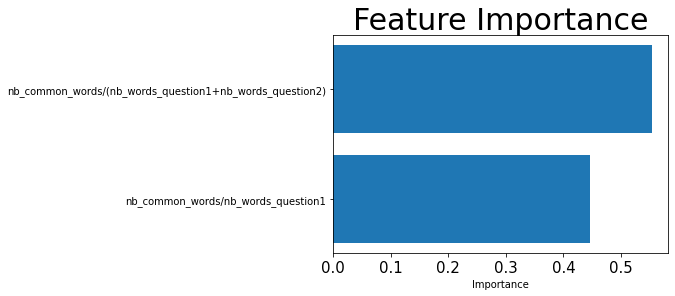

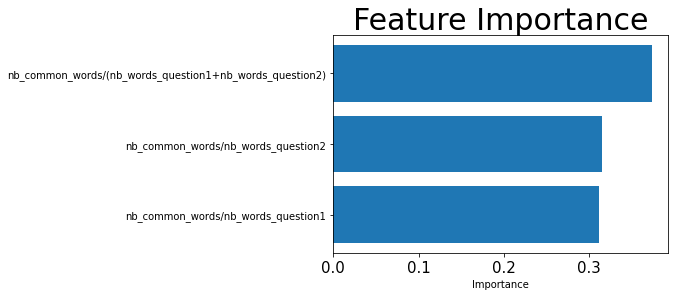

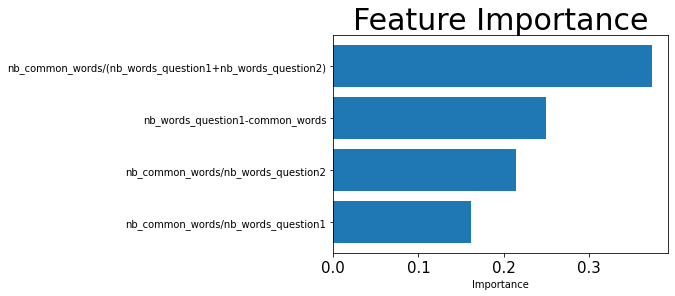

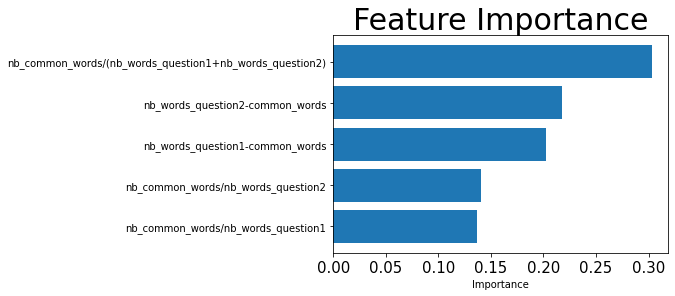

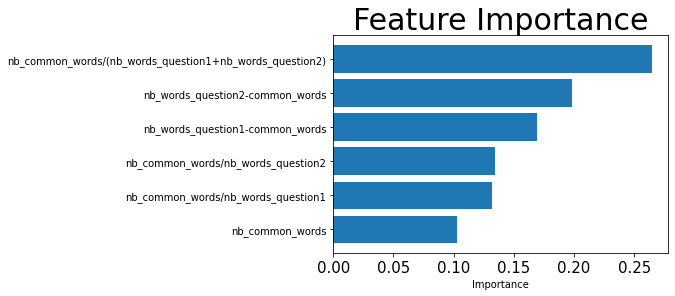

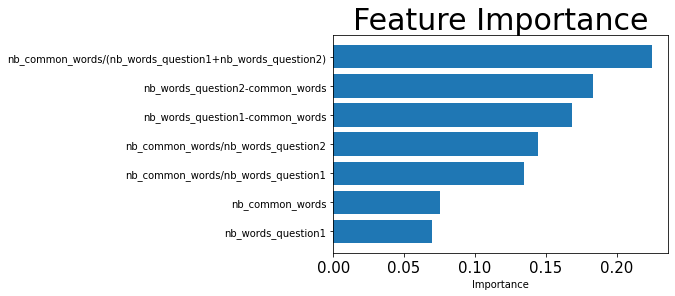

In [15]:

from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest,f_classif,RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA

def graph_relative_feature_importance(features_importances,columns):
    # Make importances relative to max importance.
    features_importances = 100.0 * (features_importances / features_importances.max())
    sorted_idx = numpy.argsort(features_importances)
    sorted_idx = sorted_idx[-20:-1:1]
    pos = numpy.arange(sorted_idx.shape[0]) + 0.5
    plot.barh(pos, features_importances[sorted_idx], align='center')
    plot.yticks(pos, columns)
    plot.xlabel('Relative Importance')
    plot.title('Relative Feature Importance', fontsize=30)
    plot.tick_params(axis='x', which='major', labelsize=15)
    sns.despine(left=True, bottom=True)
    plot.show()

def graph_feature_importance(features_importances,columns):
    # Make importances relative to max importance.
    sorted_idx = numpy.argsort(features_importances)
    sorted_idx = sorted_idx[-20:]
    pos = numpy.arange(sorted_idx.shape[0]) + 0.5
    plot.barh(pos, features_importances[sorted_idx], align='center')
    plot.yticks(pos, columns)
    plot.xlabel('Importance')
    plot.title('Feature Importance', fontsize=30)
    plot.tick_params(axis='x', which='major', labelsize=15)
    #sns.despine(left=True, bottom=True)
    plot.show()

def independant_features_analysis(name_data,input_df,target_df):
    train_df = input_df[all_numeric_columns(input_df)]
    target_df = target_df
    small = int(len(target_df)*0.05)
    small_train = train_df.sample(small,random_state=42)
    small_target = target_df.sample(small,random_state=42)
    small_weights = input_df[WEIGHT].sample(small,random_state=42)

    # be careful all_numeric will include also the target soon
    all_numeric = all_numeric_columns(input_df)
    print_section('Minimal analysis of numeric features of %s' % name_data)
    print_info('Nb features: %d' % len(all_numeric))
    print_info(str(all_numeric))
    print_info('Is there any null value ? %s' % input_df.isnull().any().any())

    compute_variances = feature_selection.VarianceThreshold()
    all_numeric.append('is_duplicate')
    variances = compute_variances.fit_transform(input_df[all_numeric])
    print_info('Is there any low variance feature ? %s' % str(variances.shape[1]!=len(all_numeric)))
    print_info('Here are the correlations to the target "is_duplicate"')
    correlation_matrix = input_df[all_numeric].corr().abs()
    print(correlation_matrix['is_duplicate'].nlargest(len(all_numeric)))

    correlation_matrix_without_is_duplicate = correlation_matrix['is_duplicate'][correlation_matrix['is_duplicate']<1]
    highest_correlated_feature = correlation_matrix_without_is_duplicate.nlargest(1).index[0]
    highest_correlation = correlation_matrix_without_is_duplicate.nlargest(1)[0]
    if highest_correlation >0.2:
        if highest_correlation < 0.5:
            print_warning('%s is the most correlated but %f is quite weak' % (highest_correlated_feature,highest_correlation))
        else:
            print_info('%s is the most correlated but %f is very weak' % (highest_correlated_feature,highest_correlation))
    else:
        print_alert('%s is the most correlated and %f is quite big' % (highest_correlated_feature,highest_correlation))
    plot.figure(figsize=(15, 10))
    sns.heatmap(correlation_matrix,annot=True,cbar=True,square=True,cmap='coolwarm',mask = numpy.triu(correlation_matrix))
    plot.show()

    # we remove is_duplicate
    all_numeric = all_numeric_columns(input_df)

    print_section('Here are the features that would be selected with a simple univariate analysis')
    start = time.time()
    for r in tqdm(range(1,len(all_numeric))):
        k_best = SelectKBest(score_func=f_classif,k=r)
        fit = k_best.fit(small_train,small_target)
        best_columns = [small_train.columns[c] for c in fit.get_support(indices=True)]
        print_info('Nb features to keep %d:%s' %(r,best_columns))
        
        # Can we graph relative importances
        if r>1:
            # transform train set so we can compute importances
            univariate_features = fit.transform(small_train)
            rfc = RandomForestClassifier(n_estimators=100)
            rfc_scores = cross_val_score(rfc, univariate_features, small_target, cv=5, scoring='neg_log_loss',n_jobs=os.cpu_count())
            features_importance = rfc.fit(univariate_features, small_target).feature_importances_
            graph_feature_importance(features_importance,best_columns)
    print_done('Done',top=start)
    
    print_section('Here are the features that would be selected a priori from default Multinomial Naive Bayes')
    start = time.time()   
    mnb = MultinomialNB()
    best_from_model = feature_selection.SelectFromModel(mnb)
    fit = best_from_model.fit(small_train,small_target,sample_weight=small_weights)
    print(fit.get_support(indices=True))
    best_columns = [small_train.columns[c] for c in fit.get_support(indices=True)]
    # transform train set so we can compute importances
    mnb_features = fit.transform(small_train)
    rfc = RandomForestClassifier(n_estimators=100)
    rfc_scores = cross_val_score(rfc, mnb_features, small_target, cv=5, scoring='neg_log_loss',n_jobs=os.cpu_count())
    features_importance = rfc.fit(mnb_features, small_target).feature_importances_
    print(features_importance)
    print_info('features to keep :%s logloss %.4f %.4f' %(best_columns,-rfc_scores.mean(),rfc_scores.std()))
    graph_feature_importance(features_importance,best_columns)
    print_done('Done',top=start)
    

    print_info('Try to keep x \% of variance with a PCA')
    print_alert('bug ?')
    start = time.time()
    for r in tqdm([.8,.9,.95]):
        acp = PCA(r)
        principal_components = acp.fit_transform(small_train)
        principal_df = pandas.DataFrame(principal_components).sample(small,random_state=42)
        rfc = RandomForestClassifier(n_estimators=100)
        rfc_scores = cross_val_score(rfc, principal_df, small_target, cv=5, scoring='neg_log_loss',n_jobs=os.cpu_count())
        features_importance = rfc.fit(principal_df, small_target).feature_importances_
        print_info('%% of variance %f:%s' %(r,'aie'))
        graph_feature_importance(features_importance,small_train.columns)
    print_done('Done',top=start)

    print_section('Here are the features that would be selected with a recursive feature elimination')
    start = time.time()
    print_alert('Doomed to fail : RFE does not support to transmit ,sample_weight=small_weights')
    print_alert('ix is waiting since 2016 ?')
    for r in tqdm(range(1,len(all_numeric))):
        mnb = MultinomialNB()
        recursive_best= feature_selection.RFE(mnb, n_features_to_select=r)
        fit = recursive_best.fit(small_train,small_target)
        best_columns = [small_train.columns[c] for c in fit.get_support(indices=True)]
        print_info('Nb features to keep %d:%s' %(r,best_columns))
        
        # Can we graph relative importances
        if r>1:
            # transform train set so we can compute importances
            recursive_features = fit.transform(small_train)
            rfc = RandomForestClassifier(n_estimators=100)
            rfc_scores = cross_val_score(rfc, recursive_features, small_target, cv=5, scoring='neg_log_loss',n_jobs=os.cpu_count())
            features_importance = rfc.fit(recursive_features, small_target).feature_importances_
            graph_feature_importance(features_importance,best_columns)
    print_done('Done',top=start)
   


independant_features_analysis('train',train_dataframe,train_dataframe['is_duplicate'])



## Here are the specs of algorithms to try

In [48]:
# Here is our algorithm specification
import xgboost 

def learner_xgboost(algo_spec,input_train,target_train,input_test,target_test,weigth_train,weight_test,show=True):
    train_dm = xgboost.DMatrix(input_train, label = target_train, weight = weigth_train)
    if target_test is None:
        watchlist = [(train_dm, 'train')]
    else:
        validation_dm = xgboost.DMatrix(input_test, label = target_test,weight = weight_test)
        watchlist = [(train_dm, 'train'), (validation_dm, 'valid')]

    start = time.time()
    if show:
        verbose = 10
    else:
        verbose = 0
    model = xgboost.train(algo_spec['params'], train_dm, 400, watchlist,early_stopping_rounds=50, verbose_eval=verbose)
    duration = time.time()-start
    return model


def predictor_xgboost(model,input_df,target_df):
    final_input = xgboost.DMatrix(input_df)
    prediction_proba_df = model.predict(final_input,ntree_limit=model.best_ntree_limit)
    prediction_df = numpy.where(prediction_proba_df>0.5,1,0)
    return prediction_df,prediction_proba_df

def scorer_xgboost(algo_spec,model,input_df,proba=True):
    # Not ready yet for False
    assert proba == True
    res = pandas.DataFrame()
    res['is_duplicate'] = model.predict(xgboost.DMatrix(input_df))
    return res


HYPER_PARAMETERS_MULTINOMIAL_NAIVE_BAYES_FIRST_TRY = [1e-10,1e-08,1e-06,1e-04,1e-02,1e-01,1.0]

HYPER_PARAMETERS_MULTINOMIAL_NAIVE_BAYES_FINE_TUNING = [0.9e-10,0.95e-10,1.0e-10,1.05e-10,1.1e-10]

ALGORITHM_SPEC_MULTINOMIAL_NB_RANDOMIZED_SEARCH = {
    'algorithm': MultinomialNB,
    'searcher': RandomizedSearchCV,
    'hyper_parameters': {
        'alpha':HYPER_PARAMETERS_MULTINOMIAL_NAIVE_BAYES_FINE_TUNING
    }
}

# Not very efficient ....
ALGORITHM_SPEC_COMPLEMENT_NB = {
    'algorithm': ComplementNB
}

ALGORITHM_SPEC_XGBOOST = {
    'learner': learner_xgboost,
    'predicter': predictor_xgboost,
    'scorer': scorer_xgboost,
    'params': {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta' : 0.02,
        'max_depth':3 
        }
}


In [17]:
# Naive Bayes

if UNITARY_TEST:
    print_section('Unitary test: one default Multinomial Naive Bayes model (80,20) & (100,0) using feature nb_words_question1')
    res = build_model_80_20_and_100_0(ALGORITHM_SPEC_COMPLEMENT_NB,train_dataframe,['nb_common_words/nb_words_question1', 'nb_words_question1-common_words', 'nb_words_question2-common_words', 'nb_common_words/(nb_words_question1+nb_words_question2)'],train_dataframe['is_duplicate'])
    #print(res)

# Unitary test
if UNITARY_TEST:
    print_section('Unitary test : optimize Multinomial Naive Bayes model with hyper_parameters (80,20) & (100,0) using feature nb_words_question1')
    res = build_model_80_20_and_100_0_hyper(ALGORITHM_SPEC_MULTINOMIAL_NB_RANDOMIZED_SEARCH,train_dataframe,['nb_common_words/nb_words_question1', 'nb_words_question1-common_words', 'nb_words_question2-common_words', 'nb_common_words/(nb_words_question1+nb_words_question2)'],train_dataframe['is_duplicate'])
    #print(res)

if UNITARY_TEST:
    print_section('Unitary test : explore all features with default Multinomial Naive Bayes model on (80,20) & (100,0)')
    small_train = train_dataframe.sample(100, random_state=42)
    small_mnb_default = build_default_model_on_all_subset_of_simple_features(ALGORITHM_SPEC_MULTINOMIAL_NB_RANDOMIZED_SEARCH,small_train,small_train['is_duplicate'])
    #print(small_mnb_default)

if UNITARY_TEST:
    print_section('Unitary test : explore all features with default Multinomial Naive Bayes model on  (80,20) & (100,0) with cross validation')
    small_train = train_dataframe.sample(100,random_state=42)
    small_mnb_cross = build_cross_validation_model_on_all_subset_of_simple_features(ALGORITHM_SPEC_MULTINOMIAL_NB_RANDOMIZED_SEARCH,small_train,small_train['is_duplicate'])
    #print(small_mnb_cross)

if UNITARY_TEST:
    print_section('Unitary test : explore all features with Multinomial Naive Bayes model & hyper parameters on (80,20) & (100,0) with hyper parameters')
    small_train = train_dataframe.sample(100,random_state=42)
    small_mnb_hyper = build_hyper_model_on_all_subset_of_simple_features(ALGORITHM_SPEC_MULTINOMIAL_NB_RANDOMIZED_SEARCH,small_train,small_train['is_duplicate'])
    #print(small_mnb_hyper)

# XGBoost 
if UNITARY_TEST:
    print_section('Unitary test : explore all features with default xgboost model on (80,20) & (100,0)')
    small_train = train_dataframe.sample(100,random_state=42)
    small_xgboost_default = build_default_model_on_all_subset_of_simple_features(ALGORITHM_SPEC_XGBOOST,small_train,small_train['is_duplicate'])
    #print(small_xgboost_default)

if UNITARY_TEST:
    print_section('Unitary test : explore all features with xgboost model on  (80,20) & (100,0) with cross validation')
    small_train = train_dataframe.sample(100,random_state=42)
    small_xgboost_cross = build_cross_validation_model_on_all_subset_of_simple_features(ALGORITHM_SPEC_XGBOOST,small_train,small_train['is_duplicate'])
    #print(small_xgboost_cross)

if UNITARY_TEST:
    model,columns = retrieve_model(small_mnb_default,'nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2)','100_0')
    assert model is not None and len(columns)==4

if UNITARY_TEST:
    model,columns = retrieve_model(small_mnb_cross,'nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2)','logloss_proba_best')
    assert model is not None and len(columns) == 4


Classification report on 80_20
              precision    recall  f1-score   support

           0       0.91      0.65      0.76 66475.35427891841
           1       0.30      0.69      0.42 14213.525233116525

    accuracy                           0.66 80688.87951203494
   macro avg       0.60      0.67      0.59 80688.87951203494
weighted avg       0.80      0.66      0.70 80688.87951203494



Classification report on 100_0
              precision    recall  f1-score   support

           0       0.91      0.66      0.76 333700.9660020216
           1       0.30      0.69      0.42 70589.0339997351

    accuracy                           0.66 404290.0000017567
   macro avg       0.60      0.67      0.59 404290.0000017567
weighted avg       0.80      0.66      0.70 404290.0000017567



Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  21 out of  25 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=7)]: Done  25 out of  25 | elapsed:    0.6s finished
Classification report on 80_20
              precision    recall  f1-score   support

           0       0.82      1.00      0.90 66475.35427891841
           1       0.00      0.00      0.00 14213.525233116525

    accuracy                           0.82 80688.87951203494
   macro avg       0.41      0.50      0.45 80688.87951203494
weighted avg       0.68      0.82      0.74 80688.87951203494



Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  21 out of  25 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=7)]: Done  25 out of  25 | elapsed:    0.8s finished
Classification report on 100_0
              precision    recall  f1-score   support

           0       0.83      1.00      0.90 333700.9660020216
           1       0.00      0.00      0.00 70589.0339997351

    accuracy                           0.83 404290.0000017567
   macro avg       0.41      0.50      0.45 404290.0000017567
weighted avg       0.68      0.83      0.75 404290.0000017567



NameError: name 'retrieve_model' is not defined

## Our playbox with XGBoost

In [18]:
import xgboost 

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta' : 0.02,
    'max_depth':3 
    }

def build_XGBoost_model_80_20(training,target,column_names,show=True):
    suffix='80_20'
    input_train,input_test,target_train,target_test = train_test_split(training,target,random_state=42,test_size=0.2)
    final_input_train = input_train[list(column_names)]
    final_input_test = input_test[list(column_names)]
    train_dm = xgboost.DMatrix(final_input_train, label = target_train, weight = input_train[WEIGHT])
    validation_dm = xgboost.DMatrix(final_input_test, label = target_test,weight = input_test[WEIGHT])
    watchlist = [(train_dm, 'train'), (validation_dm, 'valid')]

    start = time.time()
    if show:
        verbose = 10
    else:
        verbose = 0
    model = xgboost.train(params, train_dm, 400, watchlist,early_stopping_rounds=50, verbose_eval=verbose)
    duration = time.time()-start
    infos = compute_metrics_model_xgboost(model,final_input_test,target_test,suffix,sample_weight = input_test[WEIGHT],show=show)
    infos.update({add_suffix('time',suffix):duration})
    if show:      
        print_model_infos(suffix,PRINT_INFOS_ON_MODEL,infos,suffix)
    return  infos

def build_XGBoost_model_100_0(training,target,column_names,show=True):
    suffix='100_0'
    final_train = training[list(column_names)]
    final_target = target
    final_weight = training[WEIGHT]

    train_dm = xgboost.DMatrix(final_train, label = final_target, weight = final_weight)
    watchlist = [(train_dm, 'train')]

    start = time.time()
    if show:
        verbose = 10
    else:
        verbose = 0
    model = xgboost.train(params, train_dm, 400, watchlist,early_stopping_rounds=50, verbose_eval=verbose)
    duration = time.time()-start
    infos = compute_metrics_model_xgboost(model,final_train,final_target,suffix,sample_weight = final_weight,show=show)
    infos.update({add_suffix('time',suffix):duration})
    if show:      
        print_model_infos(suffix,PRINT_INFOS_ON_MODEL,infos,suffix)
    return  infos

def compute_metrics_model_xgboost(model,input_df,target_df,suffix,sample_weight = None,show = True):
    final_input = xgboost.DMatrix(input_df)
    prediction_proba_df = model.predict(final_input,ntree_limit=model.best_ntree_limit)
    prediction_df = numpy.where(prediction_proba_df>0.5,1,0)
    #prediction_proba_df = model.predict_proba(final_input,ntree_limit=model.best_ntree_limit)
    res = metrics.classification_report(target_df,prediction_df,sample_weight = sample_weight,output_dict=True)
    accuracy = res['accuracy']
    score = res['weighted avg']['f1-score']
    logloss_proba = metrics.log_loss(target_df,prediction_proba_df,sample_weight = sample_weight)
    if show:
        print('Classification report on %s' % suffix)
        print(metrics.classification_report(target_df,prediction_df,sample_weight = sample_weight))
    return add_suffix_to_keys(
            {
             'accuracy':accuracy,
             'score':score,
             'logloss_proba':logloss_proba,
             'model':model
           },
           suffix)

if UNITARY_TEST:
    print_section('Unitary test : playbox XGBoost 80_20')

if UNITARY_TEST:
    small_train = train_dataframe.sample(1000,random_state=42)
    print_section('Unitary test : playbox XGBoost 100_0')
    res = build_XGBoost_model_100_0(small_train,small_train['is_duplicate'],all_numeric_columns(small_train))
    print(res)

if UNITARY_TEST:
    small_train = train_dataframe.sample(1000,random_state=42)
    print_section('Unitary test : playbox XGBoost 80_20')
    res = build_XGBoost_model_80_20(small_train,small_train['is_duplicate'],all_numeric_columns(small_train))
    print(res)

[0]	train-logloss:0.68312
Will train until train-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.60117
[20]	train-logloss:0.54292
[30]	train-logloss:0.50033
[40]	train-logloss:0.46881
[50]	train-logloss:0.44454
[60]	train-logloss:0.42584
[70]	train-logloss:0.41138
[80]	train-logloss:0.40017
[90]	train-logloss:0.39126
[100]	train-logloss:0.38414
[110]	train-logloss:0.37851
[120]	train-logloss:0.37392
[130]	train-logloss:0.37008
[140]	train-logloss:0.36683
[150]	train-logloss:0.36411
[160]	train-logloss:0.36159
[170]	train-logloss:0.35966
[180]	train-logloss:0.35764
[190]	train-logloss:0.35586
[200]	train-logloss:0.35424
[210]	train-logloss:0.35271
[220]	train-logloss:0.35109
[230]	train-logloss:0.34996
[240]	train-logloss:0.34870
[250]	train-logloss:0.34750
[260]	train-logloss:0.34638
[270]	train-logloss:0.34532
[280]	train-logloss:0.34437
[290]	train-logloss:0.34315
[300]	train-logloss:0.34231
[310]	train-logloss:0.34114
[320]	train-logloss:0.34031
[330]	train-logloss:0.3394

{'accuracy_100_0': 0.8406167515451067, 'score_100_0': 0.7798873649808924, 'logloss_proba_100_0': 0.3336249977753858, 'model_100_0': <xgboost.core.Booster object at 0x7f0655efb640>, 'time_100_0': 1.8830299377441406}


[0]	train-logloss:0.68328	valid-logloss:0.68314
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.60240	valid-logloss:0.60009
[20]	train-logloss:0.54471	valid-logloss:0.54099
[30]	train-logloss:0.50233	valid-logloss:0.49781
[40]	train-logloss:0.47048	valid-logloss:0.46532
[50]	train-logloss:0.44663	valid-logloss:0.44162
[60]	train-logloss:0.42830	valid-logloss:0.42335
[70]	train-logloss:0.41411	valid-logloss:0.40895
[80]	train-logloss:0.40302	valid-logloss:0.39777
[90]	train-logloss:0.39388	valid-logloss:0.38859
[100]	train-logloss:0.38654	valid-logloss:0.38232
[110]	train-logloss:0.38098	valid-logloss:0.37647
[120]	train-logloss:0.37655	valid-logloss:0.37169
[130]	train-logloss:0.37282	valid-logloss:0.36799
[140]	train-logloss:0.36961	valid-logloss:0.36490
[150]	train-logloss:0.36675	valid-logloss:0.36239
[160]	train-logloss:0.36418	valid-logloss:0.36064
[170]	trai

{'accuracy_80_20': 0.8369644406229078, 'score_80_20': 0.7763626965171507, 'logloss_proba_80_20': 0.351159869815969, 'model_80_20': <xgboost.core.Booster object at 0x7f0655efbaf0>, 'time_80_20': 3.27702260017395}


## Everything ready for exploration

Algorithms available now are:
* Multinomial Naive Bayes : good results facing its simplicity
* Complement Naive Bayes (poor results)

Strategies available are
* explore all combinations with an algorithm using fixed parameters
* explore all combinations with an algorithm using fixed parameters and with cross validation
* explore all combinations with an algorithm with hyper parameters

# Very very long from now (several hours)

# All default MNB

In [30]:
def retrieve_model(results,model_key,kind):
    model = results['model_'+kind][model_key]
    column_names = results['columns'][model_key]
    return model,numpy.asarray(column_names)
    
def find_best_models(results,top,criteria,kind):
    if 'logloss' in criteria:
        return results.nsmallest(top,criteria+'_'+kind)
    else:
        return results.nlargest(top,criteria+'_'+kind)

# Explore by building default models
default_multinomial_results = build_default_model_on_all_subset_of_simple_features(ALGORITHM_SPEC_MULTINOMIAL_NB_RANDOMIZED_SEARCH,train_dataframe,train_dataframe['is_duplicate'])
save_models_dict_to_excel(default_multinomial_results,tag='default_mnb')

print_section('default Multinomial Naive Bayes')
display(default_multinomial_results.describe())
print_info('Best 3 models (logloss,80,20)')
display(find_best_models(default_multinomial_results,3,'logloss_proba','80_20'))


,logloss_proba_80_20,logloss_proba_100_0,nb_features,accuracy_80_20,accuracy_100_0,score_80_20,score_100_0,time_80_20,time_100_0
count,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000
mean,0.548301,0.545998,4.015686,0.774224,0.775400,0.745862,0.747459,0.045745,0.057223
std,0.130107,0.130046,1.397322,0.034385,0.034870,0.003495,0.003185,0.003223,0.003990
min,0.420386,0.418023,1.000000,0.724291,0.724011,0.734168,0.736875,0.039394,0.050259
25%,0.448267,0.446422,3.000000,0.740775,0.741644,0.744278,0.746450,0.043731,0.054905
50%,0.467609,0.463892,4.000000,0.775322,0.776639,0.745231,0.746896,0.045399,0.056946
75%,0.654040,0.652343,5.000000,0.799083,0.800533,0.748786,0.749984,0.047469,0.059119
max,0.854970,0.852526,8.000000,0.824181,0.825763,0.752254,0.753378,0.057079,0.075566


,logloss_proba_80_20,logloss_proba_100_0,nb_features,column_names,accuracy_80_20,accuracy_100_0,score_80_20,score_100_0,model_80_20,model_100_0,columns,time_80_20,time_100_0
nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.420386,0.418023,4,nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.823848,0.825400,0.744278,0.746450,MultinomialNB(),MultinomialNB(),"(nb_common_words/nb_words_question1, nb_words_question1-common_words, nb_words_question2-common_words, nb_common_words/(nb_words_question1+nb_words_question2))",0.051631,0.058110
nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.421546,0.419082,4,nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.823848,0.825400,0.744278,0.746450,MultinomialNB(),MultinomialNB(),"(nb_common_words/nb_words_question2, nb_words_question1-common_words, nb_words_question2-common_words, nb_common_words/(nb_words_question1+nb_words_question2))",0.047281,0.057858
nb_common_words/nb_words_question1+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words,0.421702,0.419356,4,nb_common_words/nb_words_question1+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words,0.821159,0.820746,0.750506,0.751689,MultinomialNB(),MultinomialNB(),"(nb_common_words/nb_words_question1, nb_common_words/nb_words_question2, nb_words_question1-common_words, nb_words_question2-common_words)",0.057079,0.055898


## All default MNB with cross validation

In [32]:
cross_validation_multinomial_results = build_cross_validation_model_on_all_subset_of_simple_features(ALGORITHM_SPEC_MULTINOMIAL_NB_RANDOMIZED_SEARCH,train_dataframe,train_dataframe['is_duplicate'])
save_models_dict_to_excel(cross_validation_multinomial_results,tag='crossv_mnb')

print_section('Cross validation on default multinomial NB')
display(cross_validation_multinomial_results.describe())
print_info('Best 3 models (logloss)')
display(find_best_models(cross_validation_multinomial_results,3,'logloss_proba','min'))

,logloss_proba_mean,logloss_proba_std,logloss_proba_min,logloss_proba_max,logloss_proba_best,logloss_proba_worst,logloss_proba_fold_best,logloss_proba_fold_worst,nb_features,accuracy_mean,...,accuracy_fold_best,accuracy_fold_worst,score_mean,score_std,score_min,score_max,score_best,score_worst,score_fold_best,score_fold_worsttime_mean
count,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,0.0
mean,0.545684,0.000012,0.545667,0.545699,0.545667,0.545699,3.431373,3.196078,4.015686,0.774491,...,3.478431,2.345098,0.745943,0.000006,0.745937,0.745950,0.745950,0.745937,3.690196,NaN
std,0.127110,0.000007,0.127101,0.127121,0.127101,0.127121,0.824213,1.477117,1.397322,0.033822,...,1.244881,1.324558,0.003810,0.000001,0.003809,0.003809,0.003809,0.003809,0.952670,NaN
min,0.420222,0.000006,0.420216,0.420230,0.420216,0.420230,3.000000,1.000000,1.000000,0.725577,...,1.000000,1.000000,0.734634,0.000005,0.734627,0.734644,0.734644,0.734627,3.000000,NaN
25%,0.447879,0.000007,0.447869,0.447886,0.447869,0.447886,3.000000,2.000000,3.000000,0.741487,...,3.000000,2.000000,0.743232,0.000005,0.743225,0.743241,0.743241,0.743225,3.000000,NaN
50%,0.466841,0.000008,0.466831,0.466848,0.466831,0.466848,3.000000,2.000000,4.000000,0.775427,...,3.000000,2.000000,0.746080,0.000005,0.746075,0.746087,0.746087,0.746075,3.000000,NaN
75%,0.648888,0.000017,0.648865,0.648909,0.648865,0.648909,3.000000,5.000000,5.000000,0.799128,...,5.000000,2.000000,0.748921,0.000007,0.748915,0.748927,0.748927,0.748915,5.000000,NaN
max,0.846167,0.000028,0.846131,0.846210,0.846131,0.846210,5.000000,5.000000,8.000000,0.823631,...,5.000000,5.000000,0.753088,0.000012,0.753081,0.753093,0.753093,0.753081,5.000000,NaN


,logloss_proba_mean,logloss_proba_std,logloss_proba_min,logloss_proba_max,logloss_proba_best,logloss_proba_worst,logloss_proba_fold_best,logloss_proba_fold_worst,nb_features,column_names,...,score_worst,score_fold_best,score_fold_worsttime_mean,logloss_proba_model_best,logloss_proba_model_worst,accuracy_model_best,accuracy_model_worst,score_model_best,score_model_worst,columns
nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.420222,0.000006,0.420216,0.420230,0.420216,0.420230,5,2,4,nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),...,0.743225,5,NaN,MultinomialNB(),MultinomialNB(),MultinomialNB(),MultinomialNB(),MultinomialNB(),MultinomialNB(),"(nb_common_words/nb_words_question1, nb_words_question1-common_words, nb_words_question2-common_words, nb_common_words/(nb_words_question1+nb_words_question2))"
nb_common_words/nb_words_question1+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words,0.421281,0.000006,0.421274,0.421290,0.421274,0.421290,3,2,4,nb_common_words/nb_words_question1+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words,...,0.748364,5,NaN,MultinomialNB(),MultinomialNB(),MultinomialNB(),MultinomialNB(),MultinomialNB(),MultinomialNB(),"(nb_common_words/nb_words_question1, nb_common_words/nb_words_question2, nb_words_question1-common_words, nb_words_question2-common_words)"
nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.421496,0.000006,0.421489,0.421504,0.421489,0.421504,3,2,4,nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),...,0.743225,5,NaN,MultinomialNB(),MultinomialNB(),MultinomialNB(),MultinomialNB(),MultinomialNB(),MultinomialNB(),"(nb_common_words/nb_words_question2, nb_words_question1-common_words, nb_words_question2-common_words, nb_common_words/(nb_words_question1+nb_words_question2))"


# All MNB with hyper parameters

In [35]:
#hyper_multinomial_results = build_hyper_model_on_all_subset_of_simple_features(ALGORITHM_SPEC_MULTINOMIAL_NB_RANDOMIZED_SEARCH,train_dataframe,train_dataframe['is_duplicate'])
save_models_dict_to_excel(hyper_multinomial_results,tag='hyper_mnb')

print_section('Hyper parameters multinomial NB')
display(hyper_multinomial_results.describe())
print_info('Best 3 models (logloss,80,20)')
display(find_best_models(hyper_multinomial_results,3,'logloss_proba','80_20'))

,logloss_proba_80_20,logloss_proba_100_0,nb_features,accuracy_80_20,accuracy_100_0,score_80_20,score_100_0,time_80_20,time_100_0
count,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000
mean,0.548301,0.545998,4.015686,0.774224,0.775400,0.745862,0.747459,1.164914,2.156350
std,0.130107,0.130046,1.397322,0.034385,0.034870,0.003495,0.003185,0.277225,0.481759
min,0.420386,0.418023,1.000000,0.724291,0.724011,0.734168,0.736875,0.846875,1.611999
25%,0.448267,0.446422,3.000000,0.740775,0.741644,0.744278,0.746450,0.995691,1.836243
50%,0.467610,0.463892,4.000000,0.775322,0.776639,0.745231,0.746896,1.052892,1.909169
75%,0.654040,0.652343,5.000000,0.799083,0.800533,0.748786,0.749984,1.269553,2.378857
max,0.854970,0.852526,8.000000,0.824181,0.825763,0.752254,0.753378,3.148891,4.258569


,logloss_proba_80_20,params_80_20,logloss_proba_100_0,params_100_0,nb_features,accuracy_80_20,accuracy_100_0,score_80_20,score_100_0,column_names,columns,model_100_0,model_80_20,time_80_20,time_100_0
nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.420386,{'alpha': 1.1e-10},0.418023,{'alpha': 9e-11},4,0.823848,0.825400,0.744278,0.746450,nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),"(nb_common_words/nb_words_question1, nb_words_question1-common_words, nb_words_question2-common_words, nb_common_words/(nb_words_question1+nb_words_question2))",MultinomialNB(alpha=9e-11),MultinomialNB(alpha=1.1e-10),0.955297,1.727189
nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.421546,{'alpha': 1.1e-10},0.419082,{'alpha': 1.05e-10},4,0.823848,0.825400,0.744278,0.746450,nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),"(nb_common_words/nb_words_question2, nb_words_question1-common_words, nb_words_question2-common_words, nb_common_words/(nb_words_question1+nb_words_question2))",MultinomialNB(alpha=1.05e-10),MultinomialNB(alpha=1.1e-10),0.932053,1.734617
nb_common_words/nb_words_question1+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words,0.421701,{'alpha': 1.1e-10},0.419355,{'alpha': 1.05e-10},4,0.821159,0.820746,0.750506,0.751689,nb_common_words/nb_words_question1+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words,"(nb_common_words/nb_words_question1, nb_common_words/nb_words_question2, nb_words_question1-common_words, nb_words_question2-common_words)",MultinomialNB(alpha=1.05e-10),MultinomialNB(alpha=1.1e-10),0.959024,1.795549


# All default XGBoost

In [37]:
#default_xgboost_results = build_default_model_on_all_subset_of_simple_features(ALGORITHM_SPEC_XGBOOST,train_dataframe,train_dataframe['is_duplicate'])
save_models_dict_to_excel(default_xgboost_results,tag ='xgboost_default')

print_section('Default XGBoost')
display(default_xgboost_results.describe())
print_info('Best 3 models (logloss,80,20)')
display(find_best_models(default_xgboost_results,3,'logloss_proba','80_20'))

,logloss_proba_80_20,logloss_proba_100_0,nb_features,accuracy_80_20,accuracy_100_0,score_80_20,score_100_0,time_80_20,time_100_0
count,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000
mean,0.388923,0.386261,4.015686,0.824204,0.825989,0.748331,0.750387,15.031613,16.532068
std,0.009696,0.009752,1.397322,0.000261,0.000318,0.002150,0.002166,1.758816,1.650784
min,0.384015,0.381268,1.000000,0.823592,0.825400,0.744278,0.746450,9.393470,10.482666
25%,0.385008,0.382353,3.000000,0.823974,0.825717,0.747416,0.749160,14.061311,15.609900
50%,0.385743,0.383060,4.000000,0.824234,0.826099,0.748960,0.750866,14.703809,16.173194
75%,0.387386,0.384625,5.000000,0.824389,0.826231,0.749826,0.751877,15.749570,17.184564
max,0.454803,0.452778,8.000000,0.824853,0.826461,0.752838,0.755414,26.774623,24.420083


,logloss_proba_80_20,logloss_proba_100_0,nb_features,column_names,accuracy_80_20,accuracy_100_0,score_80_20,score_100_0,model_80_20,model_100_0,columns,time_80_20,time_100_0
nb_words_question1+nb_words_question2+nb_common_words+nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.384015,0.381268,7,nb_words_question1+nb_words_question2+nb_common_words+nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_word...,0.824468,0.826297,0.749716,0.752390,<xgboost.core.Booster object at 0x7f0713f95d90>,<xgboost.core.Booster object at 0x7f06f42cb490>,"(nb_words_question1, nb_words_question2, nb_common_words, nb_common_words/nb_words_question1, nb_words_question1-common_words, nb_words_question2-common_words, nb_common_words/(nb_words_question1+...",15.754675,17.739224
nb_words_question1+nb_words_question2+nb_common_words+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.384055,0.381313,6,nb_words_question1+nb_words_question2+nb_common_words+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.824400,0.826317,0.750603,0.752495,<xgboost.core.Booster object at 0x7f06ec7e7700>,<xgboost.core.Booster object at 0x7f06ec7e7fd0>,"(nb_words_question1, nb_words_question2, nb_common_words, nb_words_question1-common_words, nb_words_question2-common_words, nb_common_words/(nb_words_question1+nb_words_question2))",19.775686,16.023210
nb_words_question1+nb_words_question2+nb_common_words+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.384077,0.381414,7,nb_words_question1+nb_words_question2+nb_common_words+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_word...,0.824417,0.826319,0.750005,0.752511,<xgboost.core.Booster object at 0x7f0713f95d00>,<xgboost.core.Booster object at 0x7f06ec7a3ac0>,"(nb_words_question1, nb_words_question2, nb_common_words, nb_common_words/nb_words_question2, nb_words_question1-common_words, nb_words_question2-common_words, nb_common_words/(nb_words_question1+...",17.774780,16.878300


# all XGBoost with cross validation

In [150]:
#cross_validation_xgboost_results = build_cross_validation_model_on_all_subset_of_simple_features(ALGORITHM_SPEC_XGBOOST,train_dataframe,train_dataframe['is_duplicate'])
save_models_dict_to_excel(cross_validation_xgboost_results,tag='xgboost_cross')

print_section('XGBoost with cross validation')
display(cross_validation_xgboost_results.describe())
print_info('Best 3 models (logloss)')
display(find_best_models(cross_validation_xgboost_results,3,'logloss_proba','min'))

,logloss_proba_mean,logloss_proba_std,logloss_proba_min,logloss_proba_max,logloss_proba_best,logloss_proba_worst,logloss_proba_fold_best,logloss_proba_fold_worst,nb_features,accuracy_mean,...,accuracy_fold_best,accuracy_fold_worst,score_mean,score_std,score_min,score_max,score_best,score_worst,score_fold_best,score_fold_worsttime_mean
count,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,0.0
mean,0.388654,0.000014,0.388635,0.388668,0.388635,0.388668,4.105882,2.027451,4.015686,0.823845,...,4.482353,2.670588,0.747777,0.000060,0.747711,0.747849,0.747849,0.747711,4.419608,NaN
std,0.009898,0.000010,0.009899,0.009897,0.009899,0.009897,0.996334,1.703179,1.397322,0.000370,...,0.877700,1.252288,0.002341,0.000102,0.002337,0.002357,0.002357,0.002337,0.909491,NaN
min,0.383554,0.000005,0.383527,0.383566,0.383527,0.383566,3.000000,1.000000,1.000000,0.823099,...,3.000000,2.000000,0.743232,0.000005,0.743225,0.743241,0.743241,0.743225,3.000000,NaN
25%,0.384675,0.000007,0.384664,0.384690,0.384664,0.384690,3.000000,1.000000,3.000000,0.823628,...,3.000000,2.000000,0.746688,0.000007,0.746681,0.746697,0.746697,0.746681,3.000000,NaN
50%,0.385398,0.000010,0.385390,0.385452,0.385390,0.385452,5.000000,1.000000,4.000000,0.823949,...,5.000000,2.000000,0.748201,0.000012,0.748135,0.748300,0.748300,0.748135,5.000000,NaN
75%,0.387039,0.000018,0.387014,0.387051,0.387014,0.387051,5.000000,2.000000,5.000000,0.824135,...,5.000000,2.000000,0.749488,0.000072,0.749430,0.749588,0.749588,0.749430,5.000000,NaN
max,0.456073,0.000065,0.456062,0.456079,0.456062,0.456079,5.000000,5.000000,8.000000,0.824487,...,5.000000,5.000000,0.752555,0.000632,0.752548,0.752564,0.752564,0.752548,5.000000,NaN


,logloss_proba_mean,logloss_proba_std,logloss_proba_min,logloss_proba_max,logloss_proba_best,logloss_proba_worst,logloss_proba_fold_best,logloss_proba_fold_worst,nb_features,column_names,...,score_worst,score_fold_best,score_fold_worsttime_mean,logloss_proba_model_best,logloss_proba_model_worst,accuracy_model_best,accuracy_model_worst,score_model_best,score_model_worst,columns
nb_words_question1+nb_words_question2+nb_common_words+nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.383554,0.000016,0.383527,0.383566,0.383527,0.383566,5,1,7,nb_words_question1+nb_words_question2+nb_common_words+nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_word...,...,0.749651,5,NaN,<xgboost.core.Booster object at 0x7f0713fa3640>,<xgboost.core.Booster object at 0x7f0713fa3b20>,<xgboost.core.Booster object at 0x7f0713fa36d0>,<xgboost.core.Booster object at 0x7f0713fa3640>,<xgboost.core.Booster object at 0x7f0713fa3640>,<xgboost.core.Booster object at 0x7f0713fa3490>,"(nb_words_question1, nb_words_question2, nb_common_words, nb_common_words/nb_words_question1, nb_words_question1-common_words, nb_words_question2-common_words, nb_common_words/(nb_words_question1+..."
nb_words_question1+nb_words_question2+nb_common_words+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.383571,0.000016,0.383556,0.383598,0.383556,0.383598,3,5,6,nb_words_question1+nb_words_question2+nb_common_words+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),...,0.749985,5,NaN,<xgboost.core.Booster object at 0x7f06e3b79af0>,<xgboost.core.Booster object at 0x7f06e3b798e0>,<xgboost.core.Booster object at 0x7f06e3b798e0>,<xgboost.core.Booster object at 0x7f06e3b793d0>,<xgboost.core.Booster object at 0x7f06e3b798e0>,<xgboost.core.Booster object at 0x7f06e3b793d0>,"(nb_words_question1, nb_words_question2, nb_common_words, nb_words_question1-common_words, nb_words_question2-common_words, nb_common_words/(nb_words_question1+nb_words_question2))"
nb_words_question1+nb_words_question2+nb_common_words+nb_common_words/nb_words_question1+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.383631,0.000032,0.383575,0.383651,0.383575,0.383651,5,1,8,nb_words_question1+nb_words_question2+nb_common_words+nb_common_words/nb_words_question1+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_commo...,...,0.749226,3,NaN,<xgboost.core.Booster object at 0x7f0713fa3910>,<xgboost.core.Booster object at 0x7f0713fa3040>,<xgboost.core.Booster object at 0x7f0713fa3910>,<xgboost.core.Booster object at 0x7f0713fa38e0>,<xgboost.core.Booster object at 0x7f0713fa32b0>,<xgboost.core.Booster object at 0x7f0713fa3910>,"(nb_words_question1, nb_words_question2, nb_common_words, nb_common_words/nb_words_question1, nb_common_words/nb_words_question2, nb_words_question1-common_words, nb_words_question2-common_words, ..."


In [236]:

import datetime

def show_docker_cp_command(absolute_file_name):
    return 'docker cp '+ DOCKER_IMAGE_NAME+':'+zip_file_name(absolute_file_name)+ ' c:\\temp\\outputs'

def show_kaggle_command(file_name,model_key):
    return 'kaggle competitions submit quora-question-pairs -f "' + zip_file_name(file_name) +'" -m "' + file_name + ':'+model_key+'"'

def show_docker_cp_commands(results):
    print_section('Use these commands to transfer apply results to windows host')
    for c in results['file_name'].apply(show_docker_cp_command):
        print_warning(c)
    print_done("")

def show_kaggle_commands(results):
    print_section('Use these commands to submit apply results to kaggle')
    results.apply(lambda r: print_warning(show_kaggle_command(r.file_name,r.model_key)),axis=1)
    print_done("")


def retrieve_model(results,criteria,kind,model_key):
    # hack
    k = 'model_'+kind
    if k in results.columns:
        model = results['model_'+kind][model_key]
    else:
        model = results[criteria+'_model_'+kind][model_key]

    column_names = results['columns'][model_key]
    return model,numpy.asarray(column_names)

# return a dataframe fully ready to be converted in csv and published into kaggle
def applyout_file_name(criteria,kind,model_key,tag=None,n=None):
    # unfortunatley our design generated huge file names :(
    # so we have to remove model_key form file name
    if n is not None:
        now = str(n)+'_'+datetime.datetime.now().strftime("%m_%d_%H_%M_%S")
    else:
        now = datetime.datetime.now().strftime("%m_%d_%H_%M_%S")
    if tag is None:
        # absolute_file_name_csv = apply_absolute_file_name(criteria,kind,model_key)
        absolute_file_name_csv = apply_absolute_file_name(criteria,kind,now)
    else:
        #absolute_file_name_csv = apply_absolute_file_name(tag+'_'+criteria,kind,model_key)
        absolute_file_name_csv = apply_absolute_file_name(tag+'_'+criteria,kind,now)
    return absolute_file_name_csv

def simple_apply(results,criteria,kind,model_key,input_dataframe,proba=True,algo_spec=None):
    model,column_names=retrieve_model(results,criteria,kind,model_key)
    assert model is not None
    assert column_names is not None
    assert len(column_names) > 0
    input_for_prediction=input_dataframe[column_names]
    res = pandas.DataFrame()
    if 'test_id' in input_dataframe.columns:
        res['test_id']=input_dataframe['test_id']
    if algo_spec is None:
        assert model.predict_proba is not None, 'Bad type of model ?'
        if proba:
            res['is_duplicate'] = pandas.Series(model.predict_proba(input_for_prediction)[:,1],name='is_duplicate')
        else:
            res['is_duplicate'] = pandas.Series(model.predict(input_for_prediction)[:,1],name='is_duplicate')
    else:
        assert'scorer' in algo_spec
        res['is_duplicate'] = algo_spec['scorer'](algo_spec,model,input_for_prediction,proba=proba)
    return res  


def submit_model(results,criteria,kind,model_key,input_dataframe,tag=None,proba=True,show_how_to_publish=True,kaggle=True,algo_spec=None,n=None):
    absolute_file_name_csv = applyout_file_name(criteria,kind,model_key,tag=tag,n=n)
    print_info('Doing apply')
    prediction = simple_apply(results,criteria,kind,model_key,input_dataframe,proba=proba,algo_spec=algo_spec)
    print_info('Generating CSV file')
    prediction.to_csv(absolute_file_name_csv,index=False)
    print_info('Zipping file')
    absolute_file_name_zip = zip_file_and_delete(absolute_file_name_csv)
    print_info('%s is ready' % absolute_file_name_zip)
    if show_how_to_publish:
        if kaggle:
            print_warning('Use this commands to submit apply results to kaggle')
            print_warning(show_kaggle_command(absolute_file_name_zip),model_key)
        else:
            print_warning('Use this command to transfer apply _results to Windows host')
            print_warning(show_docker_cp_command(absolute_file_name_csv))
    return absolute_file_name_csv
    
    
    
def submit_best_models(results,top,criteria,kind,input_dataframe,proba=True,kaggle=True,algo_spec=None,tag=None):
    best_models = find_best_models(results,top,criteria,kind)
    best_models['model_key']=numpy.asarray(best_models.index)
    best_models['num']=numpy.arange(1,top+1)
    files = list()
    for mk,n in zip(best_models['model_key'],range(1,top+1)):
        f = submit_model(results,criteria,kind,mk,input_dataframe,proba=proba,show_how_to_publish=False,kaggle=kaggle,tag=tag,algo_spec=algo_spec,n=n)
        files.append(f)
    best_models['file_name'] = files
    best_models['docker']=best_models['file_name'].apply(show_docker_cp_command)
    best_models['kaggle']=best_models.apply(show_kaggle_command,axis=1)
    print_done('Done')
    if kaggle:
        show_kaggle_commands(best_models)
    else:
        show_docker_cp_commands(best_models)
    return best_models


if UNITARY_TEST:
    print_section('Unitary test submit 3 best default xgboost')
    res = submit_best_models(
        default_xgboost_results,
        1,
        'logloss_proba','80_20',
        challenge_dataframe.sample(1000,random_state=42),
        algo_spec=ALGORITHM_SPEC_XGBOOST,
        tag='TODEL')

# Multinomial Naive Bayes
if UNITARY_TEST:
    print_section('Unitary test Simple apply Multinomial Naive Bayes')
    res = simple_apply(default_multinomial_results,'logloss_proba','80_20','nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2)',challenge_dataframe,)
    assert len(res)==len(challenge_dataframe)

if UNITARY_TEST:
    print_section('Unitary test submit multinomial Naive Bayes')
    submit_model(
        default_multinomial_results,
        'logloss_proba',
        '80_20',
        'nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2)',
        challenge_dataframe.sample(1000,random_state=42),
        tag='_TODEL_')

if UNITARY_TEST:
    print_section('Unitary test submit 3 best default multinomial Naive Bayes')
    res = submit_best_models(
        default_multinomial_results,
        3,
        'logloss_proba','80_20',
        challenge_dataframe.sample(1000,random_state=42),
        kaggle=True,
        tag='_TODEL_')

# XGBoost
if UNITARY_TEST:
    print_section('Unitary test Simple apply XGBoost')
    res = simple_apply(
        default_xgboost_results,
        'logloss_proba',
        '80_20',
        'nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2)',
        challenge_dataframe,
        algo_spec=ALGORITHM_SPEC_XGBOOST)
    assert len(res)==len(challenge_dataframe)

if UNITARY_TEST:
    print_section('Unitary test submit XGBoost')
    submit_model(
        default_xgboost_results,
        'logloss_proba',
        '80_20',
        'nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2)',
        challenge_dataframe.sample(1000,random_state=42),
        tag='_TODEL_',
        algo_spec=ALGORITHM_SPEC_XGBOOST,kaggle=False)

if UNITARY_TEST:
    print_section('Unitary test submit 3 best default xgboost')
    res = submit_best_models(
        default_xgboost_results,
        1,
        'logloss_proba','80_20',
        challenge_dataframe.sample(1000,random_state=42),
        algo_spec=ALGORITHM_SPEC_XGBOOST,
        tag='TODEL')

pouet


AttributeError: 'str' object has no attribute 'file_name'

## OK Do our scorings


In [200]:
print_section('Submit 3 best default XGBoost with test')
submit_best_models(
        default_xgboost_results,
        3,
        'logloss_proba','80_20',
        challenge_dataframe,
        algo_spec=ALGORITHM_SPEC_XGBOOST,
        tag='Default_XGBoost_with_test')

print_section('Submit 3 best default XGBoost full train')
submit_best_models(
        default_xgboost_results,
        3,
        'logloss_proba','100_0',
        challenge_dataframe,
        algo_spec=ALGORITHM_SPEC_XGBOOST,
        tag='Default_XGBoost_full_train')


print_section('Submit 3 best cross validation XGBoost')
submit_best_models(
        cross_validation_xgboost_results,
        3,
        'logloss_proba','best',
        challenge_dataframe,
        kaggle=True,
        algo_spec=ALGORITHM_SPEC_XGBOOST,
        tag='CrossVal_XGBoost')


print_section('Submit 2 best default Multinomial Naive Bayes')
submit_best_models(
        default_multinomial_results,
        2,
        'logloss_proba','80_20',
        challenge_dataframe,
        tag='Default_MNB')

print_section('Submit 2 best cross validation Multinomial Naive Bayes')
submit_best_models(
        cross_validation_multinomial_results,
        2,
        'logloss_proba','best',
        challenge_dataframe,
        tag='Cross_MNB')

print_section('Submit 2 best hyper parameters Multinomial Naive Bayes')
submit_best_models(
        hyper_multinomial_results,
        2,
        'logloss_proba','80_20',
        challenge_dataframe,
        tag='Hyper_MNB')


pouet


pouet


pouet


pouet


pouet


pouet


pouet


pouet


pouet


,logloss_proba_80_20,params_80_20,logloss_proba_100_0,params_100_0,nb_features,accuracy_80_20,accuracy_100_0,score_80_20,score_100_0,column_names,columns,model_100_0,model_80_20,time_80_20,time_100_0,model_key,num,file_name,docker,kaggle
nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.420386,{'alpha': 1.1e-10},0.418023,{'alpha': 9e-11},4,0.823848,0.8254,0.744278,0.74645,nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),"(nb_common_words/nb_words_question1, nb_words_question1-common_words, nb_words_question2-common_words, nb_common_words/(nb_words_question1+nb_words_question2))",MultinomialNB(alpha=9e-11),MultinomialNB(alpha=1.1e-10),0.955297,1.727189,nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),1,/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Hyper_MNB_logloss_proba!80_20!1_09_27_21_59_26.csv,docker cp dev_ds_1:/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Hyper_MNB_logloss_proba!80_20!1_09_27_21_59_26.zip c:\temp\outputs,"kaggle competitions submit quora-question-pairs -f ""/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Hyper_MNB_logloss_proba!80_20!1_09_27_21_59_26.zip"" -m ""/SAPDevelop/Q..."
nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.421546,{'alpha': 1.1e-10},0.419082,{'alpha': 1.05e-10},4,0.823848,0.8254,0.744278,0.74645,nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),"(nb_common_words/nb_words_question2, nb_words_question1-common_words, nb_words_question2-common_words, nb_common_words/(nb_words_question1+nb_words_question2))",MultinomialNB(alpha=1.05e-10),MultinomialNB(alpha=1.1e-10),0.932053,1.734617,nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),2,/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Hyper_MNB_logloss_proba!80_20!2_09_27_21_59_38.csv,docker cp dev_ds_1:/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Hyper_MNB_logloss_proba!80_20!2_09_27_21_59_38.zip c:\temp\outputs,"kaggle competitions submit quora-question-pairs -f ""/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Hyper_MNB_logloss_proba!80_20!2_09_27_21_59_38.zip"" -m ""/SAPDevelop/Q..."


In [235]:
def show_docker_cp_command(absolute_file_name):
    return 'docker cp '+ DOCKER_IMAGE_NAME+':'+zip_file_name(absolute_file_name)+ ' c:\\temp\\outputs'

def show_kaggle_command(r):
    return 'kaggle competitions submit quora-question-pairs -f "' + zip_file_name(r.file_name) +'" -m "' + r.file_name + ':'+r.model_key+'"'

def show_docker_cp_commands(results):
    print_section('Use these commands to transfer apply results to windows host')
    for c in results['file_name'].apply(show_docker_cp_command):
        print_warning(c)
    print_done("")

def show_kaggle_commands(results):
    print_section('Use these commands to submit apply results to kaggle')
    results.apply(lambda r: print_warning(show_kaggle_command(r)),axis=1)
    print_done("")

def submit_best_models(results,top,criteria,kind,input_dataframe,proba=True,kaggle=True,algo_spec=None,tag=None):
    best_models = find_best_models(results,top,criteria,kind)
    best_models['model_key']=numpy.asarray(best_models.index)
    best_models['num']=numpy.arange(1,top+1)
    files = list()
    for mk,n in zip(best_models['model_key'],range(1,top+1)):
        f = submit_model(results,criteria,kind,mk,input_dataframe,proba=proba,show_how_to_publish=False,kaggle=kaggle,tag=tag,algo_spec=algo_spec,n=n)
        files.append(f)
    best_models['file_name'] = files
    best_models['docker']=best_models['file_name'].apply(show_docker_cp_command)
    best_models['kaggle']=best_models.apply(show_kaggle_command,axis=1)
    print_done('Done')
    if kaggle:
        show_kaggle_commands(best_models)
    else:
        show_docker_cp_commands(best_models)
    return best_models


submit_best_models(
        hyper_multinomial_results,
        2,
        'logloss_proba','80_20',
        challenge_dataframe.sample(1000),
        tag='Hyper_MNB')



,logloss_proba_80_20,params_80_20,logloss_proba_100_0,params_100_0,nb_features,accuracy_80_20,accuracy_100_0,score_80_20,score_100_0,column_names,columns,model_100_0,model_80_20,time_80_20,time_100_0,model_key,num,file_name,docker,kaggle
nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.420386,{'alpha': 1.1e-10},0.418023,{'alpha': 9e-11},4,0.823848,0.8254,0.744278,0.74645,nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),"(nb_common_words/nb_words_question1, nb_words_question1-common_words, nb_words_question2-common_words, nb_common_words/(nb_words_question1+nb_words_question2))",MultinomialNB(alpha=9e-11),MultinomialNB(alpha=1.1e-10),0.955297,1.727189,nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),1,/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Hyper_MNB_logloss_proba!80_20!1_09_27_22_47_32.csv,docker cp dev_ds_1:/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Hyper_MNB_logloss_proba!80_20!1_09_27_22_47_32.zip c:\temp\outputs,"kaggle competitions submit quora-question-pairs -f ""/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Hyper_MNB_logloss_proba!80_20!1_09_27_22_47_32.zip"" -m ""/SAPDevelop/Q..."
nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.421546,{'alpha': 1.1e-10},0.419082,{'alpha': 1.05e-10},4,0.823848,0.8254,0.744278,0.74645,nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),"(nb_common_words/nb_words_question2, nb_words_question1-common_words, nb_words_question2-common_words, nb_common_words/(nb_words_question1+nb_words_question2))",MultinomialNB(alpha=1.05e-10),MultinomialNB(alpha=1.1e-10),0.932053,1.734617,nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),2,/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Hyper_MNB_logloss_proba!80_20!2_09_27_22_47_32.csv,docker cp dev_ds_1:/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Hyper_MNB_logloss_proba!80_20!2_09_27_22_47_32.zip c:\temp\outputs,"kaggle competitions submit quora-question-pairs -f ""/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Hyper_MNB_logloss_proba!80_20!2_09_27_22_47_32.zip"" -m ""/SAPDevelop/Q..."


In [203]:
all_submissions = load_kaggle_submissions()
display(get_last_submissions(all_submissions))
display(get_best_submissions(all_submissions))

,date,publicScore,privateScore,description,fileName
0,2020-09-27 22:02:10,0.39209,0.39605,/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Default_XGBoost_full_train_logloss_proba!100_0!3_09_27_21_57_51.csv,more_features_explorationDefault_XGBoost_full_train_logloss_proba100_03_09_27_21_57_51.zip
1,2020-09-27 22:01:56,0.39206,0.39604,/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Default_XGBoost_full_train_logloss_proba!100_0!2_09_27_21_57_39.csv,more_features_explorationDefault_XGBoost_full_train_logloss_proba100_02_09_27_21_57_39.zip
2,2020-09-27 22:01:43,0.39205,0.39602,/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Default_XGBoost_full_train_logloss_proba!100_0!1_09_27_21_57_26.csv,more_features_explorationDefault_XGBoost_full_train_logloss_proba100_01_09_27_21_57_26.zip


,publicScore,date,privateScore,description,fileName
50,0.35408,2020-09-08 21:51:27,0.35579,first xgboost,simple_xgb.csv
3,0.39204,2020-09-27 22:01:18,0.39598,/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Default_XGBoost_with_test_logloss_proba!80_20!3_09_27_21_57_13.csv,more_features_explorationDefault_XGBoost_with_test_logloss_proba80_203_09_27_21_57_13.zip
2,0.39205,2020-09-27 22:01:43,0.39602,/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Default_XGBoost_full_train_logloss_proba!100_0!1_09_27_21_57_26.csv,more_features_explorationDefault_XGBoost_full_train_logloss_proba100_01_09_27_21_57_26.zip


In [216]:
def get_best_submissions(submissions,n=3,metric='publicScore',):
    print_info('Best %d submissions based on %s' % (n,metric))
    return submissions.nsmallest(n,metric)[put_first(submissions.columns.values.tolist(),metric)].sort_values(metric,ascending=True)

def get_last_submissions(submissions,n=3):
    print_info('Last %d submissions' % n)
    return submissions.nlargest(n,'date')[put_first(submissions.columns.values.tolist(),'date')].sort_values('date',ascending=False)

display(get_last_submissions(all_submissions))
display(get_best_submissions(all_submissions,10))


,date,publicScore,privateScore,description,fileName
0,2020-09-27 22:02:10,0.39209,0.39605,/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Default_XGBoost_full_train_logloss_proba!100_0!3_09_27_21_57_51.csv,more_features_explorationDefault_XGBoost_full_train_logloss_proba100_03_09_27_21_57_51.zip
1,2020-09-27 22:01:56,0.39206,0.39604,/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Default_XGBoost_full_train_logloss_proba!100_0!2_09_27_21_57_39.csv,more_features_explorationDefault_XGBoost_full_train_logloss_proba100_02_09_27_21_57_39.zip
2,2020-09-27 22:01:43,0.39205,0.39602,/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Default_XGBoost_full_train_logloss_proba!100_0!1_09_27_21_57_26.csv,more_features_explorationDefault_XGBoost_full_train_logloss_proba100_01_09_27_21_57_26.zip


,publicScore,date,privateScore,description,fileName
50,0.35408,2020-09-08 21:51:27,0.35579,first xgboost,simple_xgb.csv
3,0.39204,2020-09-27 22:01:18,0.39598,/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Default_XGBoost_with_test_logloss_proba!80_20!3_09_27_21_57_13.csv,more_features_explorationDefault_XGBoost_with_test_logloss_proba80_203_09_27_21_57_13.zip
2,0.39205,2020-09-27 22:01:43,0.39602,/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Default_XGBoost_full_train_logloss_proba!100_0!1_09_27_21_57_26.csv,more_features_explorationDefault_XGBoost_full_train_logloss_proba100_01_09_27_21_57_26.zip
4,0.39205,2020-09-27 22:00:55,0.39601,/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Default_XGBoost_with_test_logloss_proba!80_20!1_09_27_21_56_47.csv,more_features_explorationDefault_XGBoost_with_test_logloss_proba80_201_09_27_21_56_47.zip
1,0.39206,2020-09-27 22:01:56,0.39604,/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Default_XGBoost_full_train_logloss_proba!100_0!2_09_27_21_57_39.csv,more_features_explorationDefault_XGBoost_full_train_logloss_proba100_02_09_27_21_57_39.zip
0,0.39209,2020-09-27 22:02:10,0.39605,/SAPDevelop/QuoraPairs/more_features_exploration/more_features_exploration!Default_XGBoost_full_train_logloss_proba!100_0!3_09_27_21_57_51.csv,more_features_explorationDefault_XGBoost_full_train_logloss_proba100_03_09_27_21_57_51.zip
28,0.42020,2020-09-20 19:17:00,0.42388,/SAPDevelop/QuoraPairs/multinomial_basic_features_balanced_cross_validation/multinomial_basic_features_balanced_cross_validation!logloss_proba!best!nb_common_words_div_nb_words_question1+nb_words_...,multinomial_basic_features_balanced_cross_validationlogloss_probabestnb_common_words_div_nb_words_question1nb_words_question1-common_wordsnb_words_question2-common_wordsnb_common_words_div_(nb_wor...
11,0.42027,2020-09-22 21:05:57,0.42398,/SAPDevelop/QuoraPairs/multinomial_basic_features_balanced_hyper_parameters/multinomial_basic_features_balanced_hyper_parameters!logloss_proba!100_0!nb_common_words_div_nb_words_question1+nb_words...,multinomial_basic_features_balanced_hyper_parameterslogloss_proba100_0nb_common_words_div_nb_words_question1nb_words_question1-common_wordsnb_words_question2-common_wordsnb_common_words_div_(nb_wo...
15,0.42027,2020-09-22 20:03:20,0.42398,/SAPDevelop/QuoraPairs/multinomial_basic_features_balanced_hyper_parameters/multinomial_basic_features_balanced_hyper_parameters!logloss_proba!100_0!nb_common_words_div_nb_words_question1+nb_words...,multinomial_basic_features_balanced_hyper_parameterslogloss_proba100_0nb_common_words_div_nb_words_question1nb_words_question1-common_wordsnb_words_question2-common_wordsnb_common_words_div_(nb_wo...
32,0.42027,2020-09-18 15:05:28,0.42398,/SAPDevelop/QuoraPairs/multinomial_basic_features_balanced/multinomial_basic_features_balanced!logloss_proba!full!nb_common_words_div_nb_words_question1+nb_words_question1-common_words+nb_words_qu...,multinomial_basic_features_balancedlogloss_probafullnb_common_words_div_nb_words_question1nb_words_question1-common_wordsnb_words_question2-common_wordsnb_common_words_div_(nb_words_question1nb_wo...


### Let's try XGBoost

Manual code for sandboxing before launching big stuff

In [ ]:
import xgboost 

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta' : 0.02,
    'max_depth':3 
    }

def build_XGBoost_model_80_20(training,target,column_names,show=True):
    suffix='80_20'
    input_train,input_test,target_train,target_test = train_test_split(training,target,random_state=42,test_size=0.2)
    final_input_train = input_train[list(column_names)]
    final_input_test = input_test[list(column_names)]
    train_dm = xgboost.DMatrix(final_input_train, label = target_train, weight = input_train[WEIGHT])
    validation_dm = xgboost.DMatrix(final_input_test, label = target_test,weight = input_test[WEIGHT])
    watchlist = [(train_dm, 'train'), (validation_dm, 'valid')]

    start = time.time()
    if show:
        verbose = 10
    else:
        verbose = 0
    model = xgboost.train(params, train_dm, 400, watchlist,early_stopping_rounds=50, verbose_eval=verbose)
    duration = time.time()-start
    infos = compute_metrics_model_xgboost(model,final_input_test,target_test,suffix,sample_weight = input_test[WEIGHT],show=show)
    infos.update({add_suffix('time',suffix):duration})
    if show:      
        print_model_infos(suffix,PRINT_INFOS_ON_MODEL,infos,suffix)
    return  infos

def build_XGBoost_model_100_0(training,target,column_names,show=True):
    suffix='100_0'
    final_train = training[list(column_names)]
    final_target = target
    final_weight = training[WEIGHT]

    train_dm = xgboost.DMatrix(final_train, label = final_target, weight = final_weight)
    watchlist = [(train_dm, 'train')]

    start = time.time()
    if show:
        verbose = 10
    else:
        verbose = 0
    model = xgboost.train(params, train_dm, 400, watchlist,early_stopping_rounds=50, verbose_eval=verbose)
    duration = time.time()-start
    infos = compute_metrics_model_xgboost(model,final_train,final_target,suffix,sample_weight = final_weight,show=show)
    infos.update({add_suffix('time',suffix):duration})
    if show:      
        print_model_infos(suffix,PRINT_INFOS_ON_MODEL,infos,suffix)
    return  infos

def compute_metrics_model_xgboost(model,input_df,target_df,suffix,sample_weight = None,show = True):
    final_input = xgboost.DMatrix(input_df)
    prediction_proba_df = model.predict(final_input,ntree_limit=model.best_ntree_limit)
    prediction_df = numpy.where(prediction_proba_df>0.5,1,0)
    #prediction_proba_df = model.predict_proba(final_input,ntree_limit=model.best_ntree_limit)
    res = metrics.classification_report(target_df,prediction_df,sample_weight = sample_weight,output_dict=True)
    accuracy = res['accuracy']
    score = res['weighted avg']['f1-score']
    logloss_proba = metrics.log_loss(target_df,prediction_proba_df,sample_weight = sample_weight)
    if show:
        print('Classification report on %s' % suffix)
        print(metrics.classification_report(target_df,prediction_df,sample_weight = sample_weight))
    return add_suffix_to_keys(
            {
             'accuracy':accuracy,
             'score':score,
             'logloss_proba':logloss_proba,
             'model':model
           },
           suffix)

if UNITARY_TEST:
    print_section('Unitary test : playbox XGBoost 80_20')

if UNITARY_TEST:
    small_train = train_dataframe.sample(1000,random_state=42)
    print_section('Unitary test : playbox XGBoost 100_0')
    res = build_XGBoost_model_100_0(small_train,small_train['is_duplicate'],all_numeric_columns(small_train))
    print(res)

if UNITARY_TEST:
    small_train = train_dataframe.sample(1000,random_state=42)
    print_section('Unitary test : playbox XGBoost 80_20')
    res = build_XGBoost_model_80_20(small_train,small_train['is_duplicate'],all_numeric_columns(small_train))
    print(res)
    #xgboost.plot_importance(res['model'])
    #xgboost.to_graphviz(model,num_trees=2)
